# Experiment

## Install Python dependencies

In [1]:
!pip install onnx onnxruntime tf2onnx


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Import the dependencies for the model training code:

In [2]:
import numpy as np
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tf2onnx
import onnx
import pickle
from pathlib import Path

2024-11-22 05:38:04.696402: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 05:38:04.731556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 05:38:04.731586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 05:38:04.732468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 05:38:04.737964: I tensorflow/core/platform/cpu_feature_guar

The output might show TensorFlow messages, such as a "Could not find TensorRT" warning. You can ignore these messages.


## Load the CSV data

The CSV data that you use to train the model contains the following fields:

* **distancefromhome** - The distance from home where the transaction happened.
* **distancefromlast_transaction** - The distance from the last transaction that happened.
* **ratiotomedianpurchaseprice** - The ratio of purchased price compared to median purchase price.
* **repeat_retailer** - If it's from a retailer that already has been purchased from before.
* **used_chip** - If the credit card chip was used.
* **usedpinnumber** - If the PIN number was used.
* **online_order** - If it was an online order.
* **fraud** - If the transaction is fraudulent.

In [3]:
# Set the input (X) and output (Y) data. 
# The only output data is whether it's fraudulent. All other fields are inputs to the model.

feature_indexes = [
    0,  # Call_Duration
    1,  # Data_Usage
    2,  # SMS_Count
    3,  # Roaming_Indicator
    4,  # MobileWallet_Use
    6,  # Cost
    7,  # Cellular_Location_Distance
    8,  # Personal_Pin_Used 
    9,  # Avg_Call_Duration
    10, # Avg_Data_Usage
    11  # Avg_Cost
]

label_indexes = [
    12  # fraud
]

df = pd.read_csv('data/telecom_revass_data.csv')
X = df.iloc[:, feature_indexes].values
y = df.iloc[:, label_indexes].values

print(df.info)

print(df.head)

# df = pd.read_csv('data/validate.csv')
# X_val = df.iloc[:, feature_indexes].values
# y_val = df.iloc[:, label_indexes].values

# df = pd.read_csv('data/test.csv')
# X_test = df.iloc[:, feature_indexes].values
# y_test = df.iloc[:, label_indexes].values


# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

<bound method DataFrame.info of         Call_Duration   Data_Usage  Sms_Count  Roaming_Indicator  \
0            4.692681   452.126271          1                  0   
1           30.101214   226.842467          4                  0   
2           13.167457     2.695060          3                  0   
3            9.129426   411.727859          4                  0   
4            1.696249  1134.432099          4                  0   
...               ...          ...        ...                ...   
999995      21.899784   308.629901          2                  0   
999996       5.750420  1177.784469          4                  0   
999997       5.414085   574.601579          4                  0   
999998       5.597905   206.742899          3                  0   
999999      26.514130   588.205420          2                  0   

        MobileWallet_Use Plan_Type       Cost  Cellular_Location_Distance  \
0                      0  postpaid  56.991170                    3.629675 

## Build the model

The model is a simple, fully-connected, deep neural network, containing three hidden layers and one output layer.

In [4]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=len(feature_indexes)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

## Train the model

Training a model is often the most time-consuming part of the machine learning process.  Large models can take multiple GPUs for days.  Expect the training on CPU for this very simple model to take a minute or more.

In [5]:
# Train the model and get performance
import os
import time

start = time.time()
epochs = 2
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    # validation_data=(X_val, y_val),
    verbose=True,
    class_weight=class_weights
)
end = time.time()
print(f"Training of model is complete. Took {end-start} seconds")

Epoch 1/2
21875/21875 [==============================] - 42s 2ms/step - loss: 0.0986 - accuracy: 0.9559
Epoch 2/2
21875/21875 [==============================] - 41s 2ms/step - loss: 0.0530 - accuracy: 0.9770
Training of model is complete. Took 83.96844720840454 seconds


## Save the model file

In [6]:
import tensorflow as tf

# Normally we use tf2.onnx.convert.from_keras.
# workaround for tf2onnx bug https://github.com/onnx/tensorflow-onnx/issues/2348

# Wrap the model in a `tf.function`
@tf.function(input_signature=[tf.TensorSpec([None, X_train.shape[1]], tf.float32, name='dense_input')])
def model_fn(x):
    return model(x)

# Convert the Keras model to ONNX
model_proto, _ = tf2onnx.convert.from_function(
    model_fn,
    input_signature=[tf.TensorSpec([None, X_train.shape[1]], tf.float32, name='dense_input')]
)

# Save the model as ONNX for easy use of ModelMesh
os.makedirs("models/fraud/1", exist_ok=True)
onnx.save(model_proto, "models/fraud/1/rafmmodel.onnx")

2024-11-22 05:40:27.176768: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-11-22 05:40:27.176907: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-11-22 05:40:27.284856: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-11-22 05:40:27.284973: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


The output might include TensorFlow messages related to GPUs. You can ignore these messages.

## Confirm the model file was created successfully

The output should include the model name, size, and date. 

In [7]:
! ls -alRh ./models/

./models/:
total 4.0K
drwxr-sr-x.  3 1001000000 1001000000   19 Nov 18 16:39 .
drwxr-sr-x. 14 1001000000 1001000000 4.0K Nov 22 05:39 ..
drwxr-sr-x.  3 1001000000 1001000000   15 Nov 18 16:39 fraud

./models/fraud:
total 0
drwxr-sr-x. 3 1001000000 1001000000 15 Nov 18 16:39 .
drwxr-sr-x. 3 1001000000 1001000000 19 Nov 18 16:39 ..
drwxr-sr-x. 2 1001000000 1001000000 67 Nov 22 05:08 1

./models/fraud/1:
total 32K
drwxr-sr-x. 2 1001000000 1001000000  67 Nov 22 05:08 .
drwxr-sr-x. 3 1001000000 1001000000  15 Nov 18 16:39 ..
-rw-r--r--. 1 1001000000 1001000000 13K Nov 18 16:39 model.onnx
-rw-r--r--. 1 1001000000 1001000000 14K Nov 22 05:40 rafmmodel.onnx
-rw-r--r--. 1 1001000000 1001000000   0 Nov 22 05:10 rafmmodel.pkl


## Test the model

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pickle
import onnxruntime as rt

Load the test data and scaler:

In [9]:
with open('artifact/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
with open('artifact/test_data.pkl', 'rb') as handle:
    (X_test, y_test) = pickle.load(handle)

Create an ONNX inference runtime session and predict values for all test inputs:

In [10]:
sess = rt.InferenceSession("models/fraud/1/rafmmodel.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: X_test.astype(np.float32)}) 
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.95
y_pred = np.where(y_pred_temp > threshold, 1, 0)

Show the results:

Eval Metrics: 
 Accuracy: 99.3%, Precision: 0.7279, Recall: 0.9657 



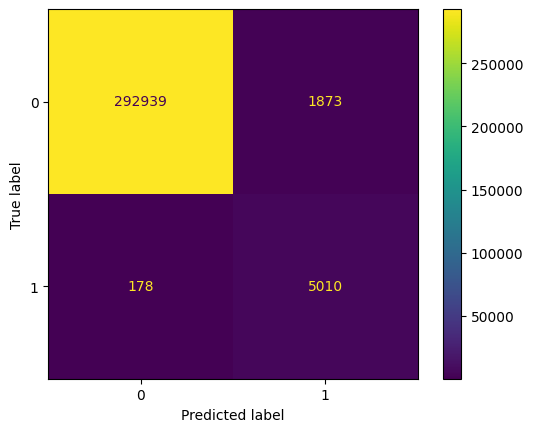

In [16]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_test_arr = y_test.squeeze()
correct = np.equal(y_pred, y_test_arr).sum().item()
acc = (correct / len(y_pred)) * 100
precision = precision_score(y_test_arr, np.round(y_pred))
recall = recall_score(y_test_arr, np.round(y_pred))

print(f"Eval Metrics: \n Accuracy: {acc:>0.1f}%, "
      f"Precision: {precision:.4f}, Recall: {recall:.4f} \n")

c_matrix = confusion_matrix(y_test_arr, y_pred)
ConfusionMatrixDisplay(c_matrix).plot()

## Example: Is below transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
 Call_Duration 10
 
 Data_Usage 300
 
 SMS_Count 5
 
 Roaming_Indicator 0
 
 MobileWallet_Use 1
 
 Cost 50
 
 Cellular_Location_Distance 3
 
 Personal_Pin_Used  20
 
 Avg_Call_Duration 12
 
 Avg_Data_Usage 350
 
 Avg_Cost 0

In [18]:

# No-fraud
# Call_Duration 10
# Data_Usage 300
# SMS_Count 5
# Roaming_Indicator 0
# MobileWallet_Use 1
# Cost 50
# Cellular_Location_Distance 3
# Personal_Pin_Used  20
# Avg_Call_Duration 12
# Avg_Data_Usage 350
# Avg_Cost


telco_transaction_details = [
    [10,
    300,
    5,
    0,
    1,
    50,
    3,
    20,
    12,
    350,
     0
     ]
    ]
prediction = sess.run([output_name], {input_name: scaler.transform(telco_transaction_details).astype(np.float32)})

print("Is transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely was this transaction to be fraudulent? ")
print("{:.5f}".format(100 * np.squeeze(prediction)) + "%")

Is transaction predicted to be fraudulent? (true = YES, false = NO) 
False
How likely was this transaction to be fraudulent? 
0.00003%


## Example: Is below transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
 #Fraud#
 
 Call_Duration 300
 
 Data_Usage 10000
 
 SMS_Count 50
 
 Roaming_Indicator 1
 
 MobileWallet_Use 1
 
 Cost 500
 
 Cellular_Location_Distance 100
 
 Personal_Pin_Used  1
 
 Avg_Call_Duration 50
 
 Avg_Data_Usage 8000
 
 Avg_Cost 0

In [19]:
telco_transaction_details = [
    [300,
    10000,
    50,
    1,
    1,
    500,
    100,
    1,
    50,
    8000,
     0
          ]
    ]

prediction = sess.run([output_name], {input_name: scaler.transform(telco_transaction_details).astype(np.float32)})

print("Is transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely was this transaction to be fraudulent? ")
print("{:.5f}".format(100 * np.squeeze(prediction)) + "%")

Is transaction predicted to be fraudulent? (true = YES, false = NO) 
True
How likely was this transaction to be fraudulent? 
100.00000%
